In [1]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import math

In [99]:
import string

In [2]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Даша\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### 1. Загрузка данных

Сначала я решила подобрать датасет, состоящий из синтетических поисковых запросов на русском языке. Этот датасет состоит из лексики, похожей на лексику в тренировочном датасете (в первой его части: до строчек из песен).  

Всего в датасете 66 категорий и 8494 запроса. 

Сначала я хотела отобрать категории, максимально похожие на данные из датасета (в этих местах стоят комментарии). Однако потом я поняла, что в таком случае словарь получается слишком маленький и качество предсказания на тестовых данных плохое.  

Также я считала файл с тестовыми данными не тем способом, который был указан в задании, потому что из-за запятых как знаков пунктуации были проблемы с разделителями. Поэтому я прочитала файл сначала построчно, потом уже отредактировала данные и получила таблицу в пандасе.  

Также я создавала некоторые лишние столбцы, которые потом не использовались, потому что делала разные форматы входных данных для разных способов их обработки (просто чтобы к этому не возвращаться).

In [486]:
splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/EmbeddingStudio/synthetic-search-queries-ru/" + splits["train"])

In [487]:
# good_categories = [
#     "Pet Supplies",
#     "Retail Stores (Online and Offline)",
#     "Books and Media",
#     "Food and Grocery",
#     "Health and Beauty",
#     "Toys and games",
#     "Electronics"
# ]

# df_good_categories = df[df["category"].isin(good_categories)]
# df_good_categories = df_good_categories.drop(columns="Parsed")
df_good_categories = df.drop(columns="Parsed")

In [488]:
df_good_categories.groupby(["category"])["category"].count()

category
Artificial Intelligence and Machine Learning    123
Automotive Dealerships                          118
Banking Services                                 72
Books and Media                                 127
Cloud Computing Services                        151
                                               ... 
Travelers and Consumers                          64
User Interface/User Experience Design           101
Version Control Systems                          87
Video Hosting and Portals                       311
Web Development                                 104
Name: category, Length: 66, dtype: int64

In [489]:
df_good_categories

,Query,category
0,"Показать пользователей из Самары, активных по ...",Dating Apps
1,Авиабилеты в Париж на весну,Travelers and Consumers
2,Покажите верхнюю одежду для мужчин с рейтингом...,Fashion and Apparel
3,"Показать все негативные отзывы, оставленные 15...",Customer Support and Feedback
4,Вилла номер три,International Real Estate
...,...,...
8489,"Нужна консультация по налогам для ИП, рассчиты...",Taxation Services
8490,Купить костюм рядом с Проспектом Мира,Fashion and Apparel
8491,где мне посмотреть задание четыре,Healthcare Providers
8492,Предоставьте список компаний с минимальным рей...,Risk Management and Compliance


In [490]:
df_good_categories = df_good_categories.drop(columns="category")

In [491]:
with open("./dataset_1937770_3.txt", "r", encoding="utf-8") as f:
    contents = f.readlines()
    contents = contents[1:]
    for i in range(len(contents)):
        pos = contents[i].find(",")
        contents[i] = [contents[i][:pos], contents[i][pos+1:-1].lower()]

df_test = pd.DataFrame(contents, columns=["id", "text_no_space"])

In [492]:
df_test

,id,text_no_space
0,0,куплюайфон14про
1,1,ищудомвподмосковье
2,2,сдаюквартирусмебельюитехникой
3,3,новыйдивандоставканедорого
4,4,отдамдаромкошку
...,...,...
1000,1000,янеусну.
1001,1001,весна-яуженегреюпио.
1002,1002,весна-скоровырастеттрава.
1003,1003,"весна-выпосмотрите,каккрасиво."


### 2. Подготовка данных

Сначала я подготовила текст. Тренировочные данные (из найденного датасета) и привела к нижнему регистру и удалила пунктуационные символы и цифры. Я понимаю, что они используются в тестовом наборе и что их нужно учитывать (я впоследствии вернулась к ним и учитывала). Но на основе тренировочных данных я составила словарь и не хотела, чтобы туда попадали данные "слова", так как это сильно путало модель впоследствии. Я позже вернулась к обработке пунктуационных знаков и чисел через эвристики, но на данном этапе я их не использовала.

Также я проделала ту же самую подготовку для тренировочных данных.

In [493]:
def prepare_text(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    pattern = "[" + re.escape(string.punctuation) + "]+"
    text = re.sub(pattern, "", text)
    return text

def find_spaces(text):
    positions = []
    n = len(text)
    for i in range(n):
        if text[i]==" ":
            positions.append(i)
    return positions

def delete_spaces(text):
    text_no_spaces = re.sub(" ", "", text)
    return text_no_spaces

In [494]:
df_good_categories["Query_prepared"] = df_good_categories["Query"].apply(lambda x: prepare_text(x))

In [495]:
df_good_categories["text_no_spaces"] = df_good_categories["Query"].apply(lambda x: delete_spaces(x))

In [496]:
df_good_categories

,Query,Query_prepared,text_no_spaces
0,"Показать пользователей из Самары, активных по ...",показать пользователей из самары активных по в...,"ПоказатьпользователейизСамары,активныхповоскре..."
1,Авиабилеты в Париж на весну,авиабилеты в париж на весну,АвиабилетывПарижнавесну
2,Покажите верхнюю одежду для мужчин с рейтингом...,покажите верхнюю одежду для мужчин с рейтингом,Покажитеверхнююодеждудлямужчинсрейтингом4.5
3,"Показать все негативные отзывы, оставленные 15...",показать все негативные отзывы оставленные,"Показатьвсенегативныеотзывы,оставленные15.06.2023"
4,Вилла номер три,вилла номер три,Вилланомертри
...,...,...,...
8489,"Нужна консультация по налогам для ИП, рассчиты...",нужна консультация по налогам для ип рассчитыв...,"НужнаконсультацияпоналогамдляИП,рассчитываюна1..."
8490,Купить костюм рядом с Проспектом Мира,купить костюм рядом с проспектом мира,КупитькостюмрядомсПроспектомМира
8491,где мне посмотреть задание четыре,где мне посмотреть задание четыре,гдемнепосмотретьзаданиечетыре
8492,Предоставьте список компаний с минимальным рей...,предоставьте список компаний с минимальным рей...,Предоставьтесписоккомпанийсминимальнымрейтинго...


In [497]:
df_test["text_no_space_prepared"]=df_test["text_no_space"].apply(lambda x: prepare_text(x))
df_test

,id,text_no_space,text_no_space_prepared
0,0,куплюайфон14про,куплюайфонпро
1,1,ищудомвподмосковье,ищудомвподмосковье
2,2,сдаюквартирусмебельюитехникой,сдаюквартирусмебельюитехникой
3,3,новыйдивандоставканедорого,новыйдивандоставканедорого
4,4,отдамдаромкошку,отдамдаромкошку
...,...,...,...
1000,1000,янеусну.,янеусну
1001,1001,весна-яуженегреюпио.,веснаяуженегреюпио
1002,1002,весна-скоровырастеттрава.,веснаскоровырастеттрава
1003,1003,"весна-выпосмотрите,каккрасиво.",веснавыпосмотритекаккрасиво


### 3. Составление словаря

Здесь я составляю словарь для данных из тренировочного датасета, также учитываю частоту слов.

In [498]:
vocab_list = []
for text in df_good_categories["Query_prepared"]:
    text = text.split()
    vocab_list.extend(text)

In [499]:
vocab = Counter(vocab_list)

## 4.  Вариант 1: динамическое программирование

Это решение на Mean F1 = 59.009%.

В этом пункте описана сама модель. Для решения задачи я использовала метод: словарь + вероятностная модель + динамическое программирование. Реализация этой модели в функции train_dyn_prog. Восстановление разделения слов на основе решения задачи динамического программирования описано в функции get_positions_from_dp. В функции get_positions описано получение позиций для каждого разделения на слова + эвристики (ниже опишу подробнее). В функции insert_space происходит восстановление пробелов в исходном тексте (который без пробелов).

Описание математической модели:

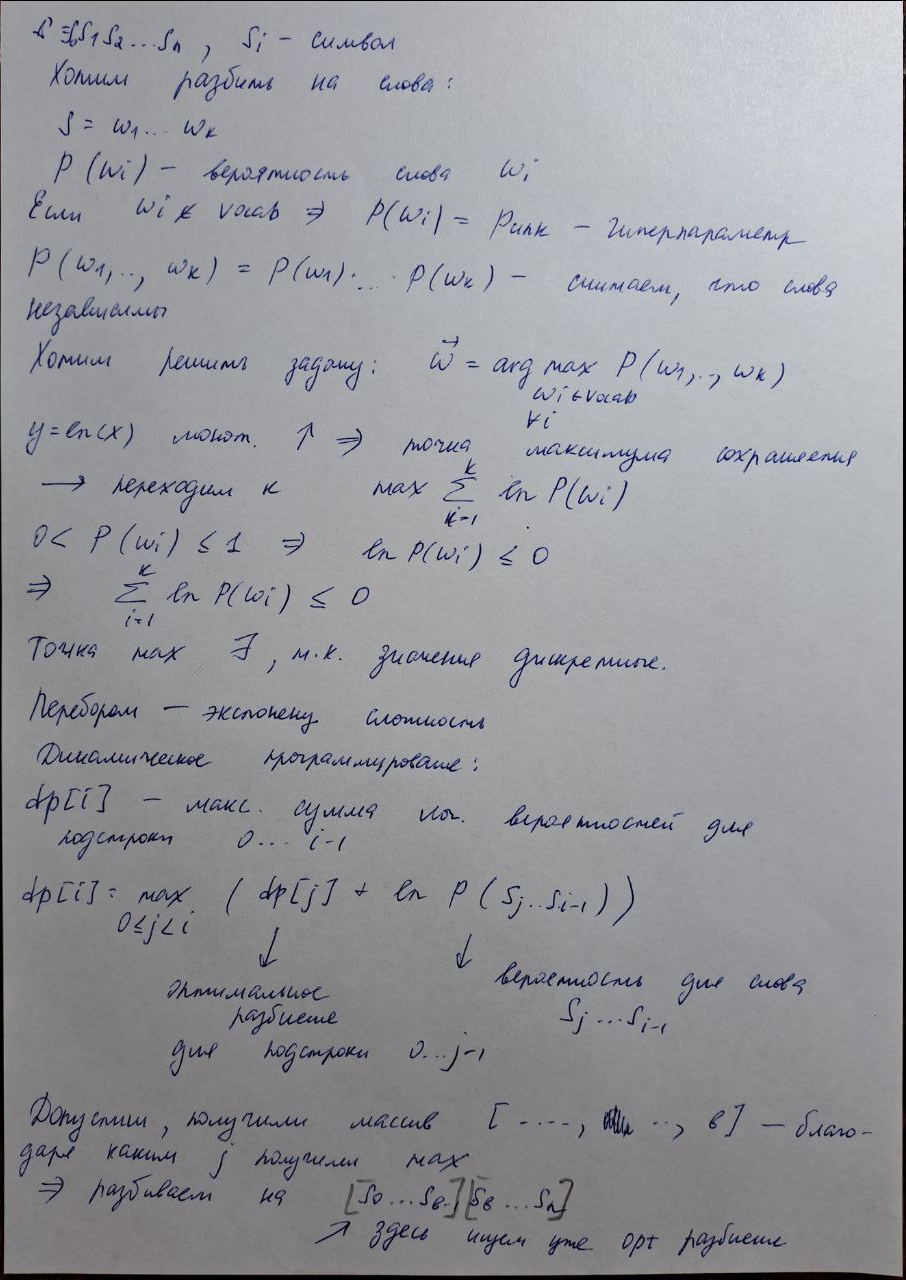

In [507]:
def train_dyn_prog(df, vocab, unk = -200, column="text_no_space_prepared"):
    """
     Args:
        df (DataFrame): Таблица, из которой берутся тексты.
        vocab (dict): Словарь (слова: частоты)
        unk (int): Гиперпараметр: стоимость использования неизвестного слова.
        column (str): Столбец, из которого извлекаются данные.
        
    Returns:
        list: Значение оптимальной функции для i-ой позиции.
        list: Значения разбиения, из которых были получены оптимальные значения.
    
    """
    dp_for_df = []
    optimal_j_for_df = []
    total = sum(vocab.values())
    for text in df[column]:
        n = len(text)
        dp = [-float("inf")]*(n+1)
        dp[0] = 0
        optimal_j = [-1]*(n+1)
        for i in range(n+1):
            j_max = -1
            value_max = -float("inf")
            for j in range(0, i):
                current_word = text[j:i]
                len_word = i-j
                #добавляем штраф в зависимости от длины слова: если длинное - то плохо, если короткое - тоже
                if len_word <= 3:
                    k = 10.0
                elif len_word >= 9:
                    k = 10.0
                else:
                    k = 1.0
                    
                #такие однобуквенные слова в русском языке есть, других - нет
                can_be_words = ["а", "и", "о", "с", "к", "у", "в", "я"]
                if len_word==1 and current_word not in can_be_words:
                    continue
                    
                if vocab.get(current_word) is None:
                    freq = unk*k
                else:
                    freq = math.log(vocab[current_word]/total)*k
                current_value = dp[j] + freq
                if current_value>value_max:
                    value_max = current_value
                    j_max = j
            if i>0:
                dp[i] = value_max
                optimal_j[i] = j_max
        dp_for_df.append(dp)
        optimal_j_for_df.append(optimal_j)
        
    return dp_for_df, optimal_j_for_df

def get_positions_from_dp(df, optimal_j, column="text_no_space_prepared"):
    """
     Args:
        df (DataFrame): Таблица, из которой берутся тексты.
        optimal_j (list): Значения разбиения, из которых были получены оптимальные значения.
        column (str): Столбец, из которого извлекаются данные.
        
    Returns:
        list: Тексты, в которых размещены "найденные" пробелы.
        list: Позиции, на которые были поставлены пробелы исходя из решения ДП
    
    """
    
    #восстанавливаем оптимальное разбиение на слова
    positions = []
    texts_with_spaces = []
    i = 0
    for text in df[column]:
        current_text = []
        positions_current = []
        start=optimal_j[i][-1]
        prev_start = len(text)+1
        while start!=-1:
            current_text.insert(0, text[start:prev_start])
            positions_current.append(start-1)
            prev_start = start
            start = optimal_j[i][start]
        texts_with_spaces.append(" ".join(current_text))
        positions.append(positions_current)
        i+=1
    return texts_with_spaces, positions

def get_positions(df, text_with_spaces, positions):
    """
     Args:
        df (DataFrame): Таблица, из которой берутся тексты.
        text_with_spaces (list): Тексты, в которых размещены "найденные" пробелы.
        positions (list): Позиции, на которые были поставлены пробелы исходя из решения ДП
        
    Returns:
        list: Финальные значения позиций, на которые были поставлены пробелы исходя из решения ДП + эвристики.
        list: Финальные тексты, в которых размещены "найденные" пробелы.
    
    """
    text = df["text_no_space"].to_list()
    n = len(text)
    final_positions = []
    new_text = []
    for i in range(n):
        current_position = []
        #если найдена подстрока из цифр, то поставим пробел перед этой подстрокой и после
        for j in re.finditer(r"\d+", text[i]):
            current_position.append(j.start())
            current_position.append(j.end())
        pattern = "[" + re.escape(string.punctuation) + "]+"
        #если найдена подстрока из пунктуационных знаков, то пробел поставим после
        for j in re.finditer(pattern, text[i]):
            current_position.append(j.end())
        text_temp = text_with_spaces[i].split()
        offset = 0
        #получаем позиции исходя из решения задачи ДП
        #так как изначально мы удалили цифры и пункт. знаки, 
        #то нужно правильно и аккуратно восстановить порядок с учетом того, что было удалено
        for j in range(len(text_temp)):
            x = r"[^а-яА-Яa-zA-Z]*".join(list(text_temp[j]))
            if (j!=len(text_temp)-1):
                match = re.search(x, text[i][offset:])
                current_position.append(offset + match.end())
                offset = offset + match.end()
        current_position = sorted(set(current_position))
        if text[i][-1] in string.punctuation:
            current_position = current_position[:-1]
        final_positions.append(current_position)
        new_text.append(insert_space(text[i], current_position))
    return final_positions, new_text
    

def insert_space(text, positions):
    """
     Args:
        text_with_spaces (str): Текст, в котором отсутствуют пробелы.
        positions (list): Финальные позиции, на которые были поставлены пробелы исходя из решения ДП + эвристик
        
    Returns:
        str: Финальная строка (для проверки адекватности разбиения на пробелы)
    """
    new_str = ""
    last_i = 0
    for i in positions:
        new_str += text[last_i:i] + " "
        last_i = i
    new_str+=text[last_i:]
    return new_str

In [508]:
_, optimal_j = train_dyn_prog(df_test, vocab)

In [509]:
texts_with_spaces, positions = get_positions_from_dp(df_test, optimal_j)

In [510]:
num = 25
print(texts_with_spaces[num])
print(df_test["text_no_space"][num])

куплю playsta tionдиск
куплюplaystation5диск


In [511]:
final_positions, new_text = get_positions(df_test, texts_with_spaces, positions)

In [513]:
df_save = df_test.copy()
df_save["predicted_positions"] = final_positions
df_save = df_save.drop(columns=["text_no_space", "text_no_space_prepared"])
df_save["predicted_positions"] = df_save["predicted_positions"].astype(str)

In [514]:
df_save

,id,predicted_positions
0,0,"[5, 10, 12]"
1,1,"[3, 6, 7]"
2,2,"[4, 12, 13, 21]"
3,3,"[5, 10, 18]"
4,4,[7]
...,...,...
1000,1000,[]
1001,1001,"[5, 6, 11]"
1002,1002,"[5, 6, 11, 16]"
1003,1003,"[5, 6, 12, 19, 21]"


In [442]:
df_save.to_csv("output.csv", index=False, encoding="utf-8")

Вывод: достаточно хорошо разбиваются реплики, которые состоят из типичных для поисковых запросов слов "куплю", "ищу". Если все слова из текста присутствуют в словаре, то обычно разбиение на выходе адекватное. Модель также часто путается из-за названий предметов и из-за различных грамматических форм для слов. Также для использования такого метода нужно иметь большой словарь, которые дополнительно должен быть раздут разными числами (множественное или единственное число слова), падежами, склонениями и тд, либо нужно искать модель, которая учитывает семантику и похожесть слов.   

Также такой способ вычислительно затратный, так как в функции для динамического программирования сложность алгоритма О(n * k^2), где n - колво текстов для обработки, k - длина текста (возьмем длину худшего текста). В нашей задаче размерность не сильно большая, поэтому не страшно, но для обработки огромных массивов информации это может считаться часами. 

Независимо от модели, на мой взгляд, очень хорошо подойдут использованные в моем решении эвристики. Они простые для алгоритмического описания (конечно, можно добавить еще больше краевых случаев), но являются эффективными. Напомню их: не рассматривать однобуквенные слова из букв, которые не встречаются в однобуквенных словах в русском языке ("м", "п" и т.д.). Также перед числом ставится пробел и в конце числа тоже (можно добавить связь с пунктуационными знаками и улучшить эвристику). Перед пунктуационным знаком пробел не ставится, а после ставится (если у нас пунктуационный знак не в самом конце строки).